In [1]:
# common imports
import numpy as np
import os
import random

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

# Path variables
PROJECT_ROOT_DIR = "."
MODEL_PATH = os.path.join(PROJECT_ROOT_DIR, "models")
DATA_PATH = os.path.join(PROJECT_ROOT_DIR, "data")
logging_dir = os.path.join(PROJECT_ROOT_DIR, "my_logs_3")
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(DATA_PATH, exist_ok=True)

In [ ]:
# torch imports
import torch, torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim

# Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

%load_ext tensorboard

In [ ]:
# Function for setting the seed
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        
set_seed(42)

In [ ]:
# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Again, define the device, if available:

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

# Practicals 3 - Pytorch: More complicated Models for Images: ResNet, Inception

In this tutorial, we define more complicated and better CNN models for image classification: ResNet and Inception. Particularly ResNet is frequently used in all ML tasks that involve images and the underlying concept is also used in other architectures like the transformer (used for ChatGPT, in Stable Diffusion, etc...)

We have two aims: understand how Inception and ResNet work (particularly the latter), and while doing so, getting more aquainted with Pytorch.

Recall the training function of the last practicals: 

In [ ]:
# Import tensorboard logger from PyTorch
from torch.utils.tensorboard import SummaryWriter

def train_model_with_logger(model, optimizer, data_loader, val_loader, loss_module, num_epochs=50, logging_dir=logging_dir):
    # Create TensorBoard logger
    writer = SummaryWriter(logging_dir)
    model_plotted = False

    val_scores = []
    # Training loop
    for epoch in range(num_epochs):
        epoch_loss = 0.0
        true_preds, num_preds = 0.0, 0.0

         # Set model to train mode
        model.train()

        for data_inputs, data_labels in data_loader:

            ## Step 1: Move input data to device (only strictly necessary if we use GPU)
            data_inputs = data_inputs.to(device)
            data_labels = data_labels.to(device)

            # For the very first batch, we visualize the computation graph in TensorBoard
            if not model_plotted:
                writer.add_graph(model, data_inputs)
                model_plotted = True

            ## Step 2: Run the model on the input data
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1) # Output is [Batch size, 1], but we want [Batch size]

            ## Step 2.5: Compute the predicted label
            preds_labels = preds.argmax(dim=-1) 

            ## Step 3: Calculate the loss 
            loss = loss_module(preds, data_labels)
            
            ## Step 4: Perform backpropagation
            # Before calculating the gradients, we need to ensure that they are all zero.
            # The gradients would not be overwritten, but actually added to the existing ones.
            optimizer.zero_grad()
            # Perform backpropagation
            loss.backward()

            ## Step 5: Update the parameters
            optimizer.step()

            ## Step 6: Take the running average of loss and update true
            epoch_loss += loss.item()
            ## Step 6.5: update number of correct predictions und number of predictions
            true_preds += (preds_labels==data_labels).sum()
            num_preds += data_labels.shape[0]
        
        # Validation at the end of training: 
        [val_loss, val_acc] = eval_model(model, val_loader, loss_module)
        val_scores.append(val_acc)

        # Add average loss to TensorBoard
        epoch_loss /= len(data_loader)
        writer.add_scalar('training_loss',
                          epoch_loss,
                          global_step = epoch + 1)
        
        # Add training accuracy to TensorBoard
        epoch_acc = true_preds/num_preds
        writer.add_scalar('training_accuracy',
                          epoch_acc,
                          global_step = epoch + 1)
        
        # Add validation loss to TensorBoard
        writer.add_scalar('validation_loss',
                          val_loss,
                          global_step = epoch + 1)
        
        # Add validation accuracy to TensorBoard
        writer.add_scalar('validation_accuracy',
                          val_acc,
                          global_step = epoch + 1)

        # Produce the output
        print(f'''Epoch: {epoch} Training loss: {epoch_loss:.2f} Training accuracy: {epoch_acc:.2f} Validation loss: {val_loss:.2f} Validation accuracy: {val_acc:.2f}''')

    writer.close()

Modify it to have an additional argument `scheduler`, and use this scheduler in the training algorithm to decrease the learning rate after each epoch using `scheduler.step()`

In [ ]:
def train_model_with_logger(model, optimizer, scheduler, data_loader, val_loader, loss_module, num_epochs=50, logging_dir=logging_dir):
    # continue

Also, recall the evaluation function: 

In [ ]:
def eval_model(model, data_loader, loss_module):
    model.eval() # Set model to eval mode
    loss = 0.0
    true_preds, num_preds = 0., 0.

    with torch.no_grad(): # Deactivate gradients for the following code
        for data_inputs, data_labels in data_loader:

            # Determine prediction of model on dev set
            data_inputs, data_labels = data_inputs.to(device), data_labels.to(device)
            preds = model(data_inputs)
            preds = preds.squeeze(dim=1)
            pred_labels = preds.argmax(dim=-1) 

            # Keep records of predictions for the accuracy metric (true_preds=TP+TN, num_preds=TP+TN+FP+FN)
            true_preds += (pred_labels == data_labels).sum()
            num_preds += data_labels.shape[0]

            # Compute the batch's loss
            loss += loss_module(preds, data_labels).item()


    acc = true_preds / num_preds
    loss /= len(data_loader)
    return [loss, acc]

You can use these functions to initialize and train the models in this tutorial.

Throughout this tutorial, we will train and evaluate the models on the CIFAR10 dataset. This allows you to compare the results obtained here with the model you have implemented in the last assignment. As we have learned from the previous tutorial about initialization, it is important to have the data preprocessed with a zero mean. Therefore, as a first step, we will calculate the mean and standard deviation of the CIFAR dataset. 

- First define the `train_dataset` as `CIFAR10` with `train=True` and without transformation, because we first want to simply use it to determine mean and std. 



First, define a `test_transform` via [`transforms.Compose`](https://pytorch.org/vision/main/generated/torchvision.transforms.Compose.html) which first turns the data into tensors and then normalizes the data. 

In the next cell, use `transforms.Compose` to define a transformation pipeline called `train_transform` with the following steps in order: 
- random horizontal flip
- random resized crop with `scale=(0.8,1.0),ratio=(0.9,1.1)`
- transform to tensor
- normalize like before

Use these transforms to load the `train_dataset` again with the `train_transform`, and the `test_set` with the `test_transform`. 

Next we want to split the training dataset into a training and a validation set with `torch.utils.data.random_split`: 
Load the train dataset twice, and split it twice with the same random seed, once with the `train_transforms`, once with `test_transforms`. Keep the `train_set` from the first, and the `val_set` from the latter. 

Now define three DataLoaders `train_loader`, `val_loader`, and `test_loader` with `batch_size=128`. 

### Inception Block

The [GoogleNet](https://arxiv.org/abs/1409.4842), proposed in 2014, won the ImageNet Challenge because of its usage of the Inception modules. In general, we will mainly focus on the concept of Inception in this tutorial instead of the specifics of the GoogleNet. 

An Inception block basically answers the question: "How large should my filters be or should I use maxpool instead?" by letting the model itself choose between the different modules itself: 1x1, 3x3, and 5x5 convolution, and a max-pool operation. 

The inception block consists of four convolution blocks "in parallel": they all take the same input, and the outputs are concatenated. Therefore, the model can decide via the "ingoing weights" how much emphasis to put on each filter. If 3x3 filter is the best choice, it might learn larger weights going into the 3x3 module than into the other modules. 

Of course, learning only 5x5 convolution would be theoretically more powerful, because there are more weights to learn. However, this is not only more computation and memory heavy but also tends to overfit much easier. A simplified version of the inception block looks like below (figure credit - [Szegedy et al.](https://arxiv.org/abs/1409.4842)):

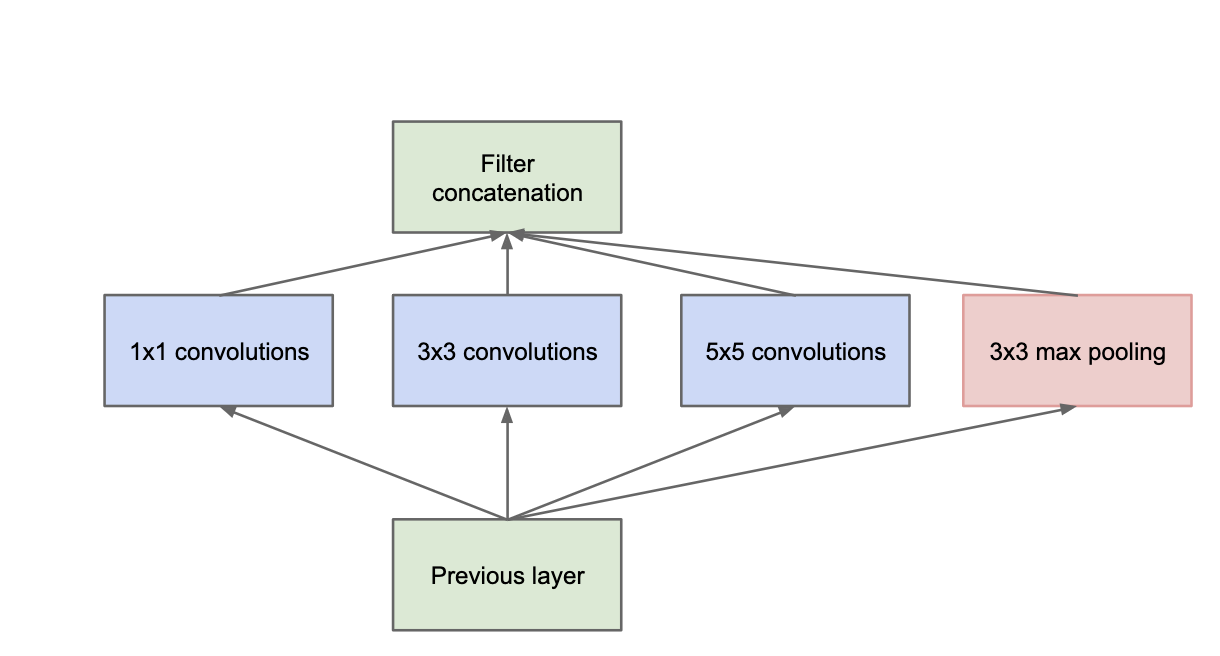


The actual inception module has a slight modification: The additional 1x1 convolutions before the 3x3 and 5x5 convolutions are used for dimensionality reduction. This is especially crucial as the feature maps of all branches are merged afterward, and we don't want any explosion of feature size

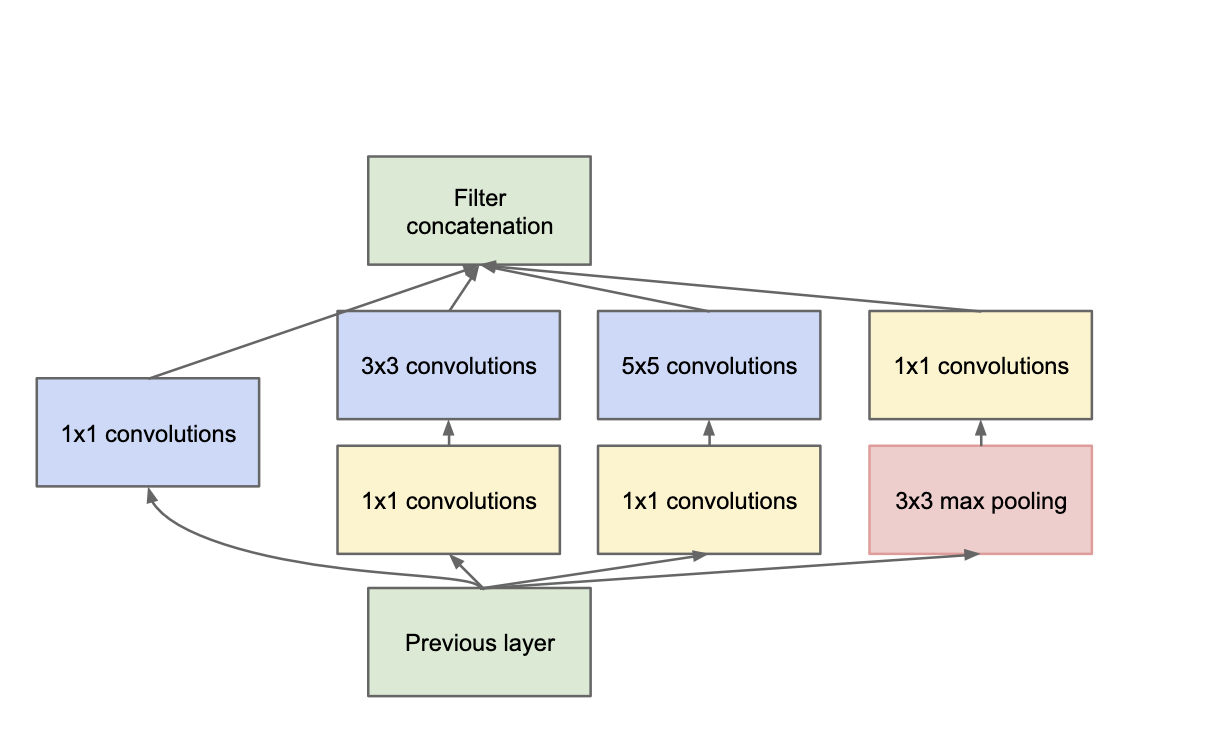


We can now try to implement the Inception Block ourselves:

Why can 1x1 convolution be used as dimensionality reduction? Explain below!

#TODO


We can now try to implement the Inception Block ourselves:

Fill out the missing parts in the below code defining the class of the Inception Block: 

First, the 1x1 convolution branch `self.conv_1x1` should consist of the following layers: (you find info on the pytorch layers in the [documentation](https://pytorch.org/docs/stable/nn.html#convolution-layers)):
- 1x1 (kernel size = 1) convolution with `c_in` input channels and `c_out["1x1"]` output channels, 
- Batch Normalization Layer
- the activation function `act_fn()`

Secondly, the 3x3 convolution branch `self.conv_3x3` should consist of the following layers: (you find info on the pytorch layers in the [documentation](https://pytorch.org/docs/stable/nn.html#convolution-layers)):
- 1x1 (kernel size = 1) convolution with `c_in` input channels and `c_red["3x3"]` output channels, 
- Batch Normalization Layer
- the activation function `act_fn()`
- 3x3 SAME convolution (which padding dimension do you need?) and output channels = `c_out["3x3"]`
- Batch Normalization Layer
- the activation function `act_fn()`

Thirdly, the 5x5 convolution branch should consist of the following layers: 
- 1x1 (kernel size = 1) convolution with `c_in` input channels and `c_red["5x5"]` output channels, 
- Batch Normalization Layer
- the activation function `act_fn()`
- 5x5 SAME convolution (which padding dimension do you need?) and output channels = `c_out["5x5"]`
- Batch Normalization Layer
- the activation function `act_fn()`

Lastly, the maxpool branch should consist of the following layers: 
- MaxPool Layer with `kernel_size=3, padding=1, stride=1`
- 1x1-convolution with `c_in` input channels and `c_out["max"]` output channels
- Batch Normalization layer
- the activation function `act_fn()`

The forward function: The output should be the concatenation along dimension 1 (use [`torch.cat`](https://pytorch.org/docs/stable/generated/torch.cat.html)) of all four branches defined in `__init__` applied to the input $x$. 


In [ ]:
class InceptionBlock(nn.Module):
    
   #continue
        

**Question:** 
- What is the number of out-channels for all branches and what is the output dimension?
- What is the number of weights and biases of each branch in one Inception Block if the input size is HxBxC?

**Answer:** TODO

The GoogleNet architecture consists of stacking multiple Inception blocks with occasional max pooling to reduce the height and width of the feature maps. The original GoogleNet was designed for image sizes of ImageNet (224x224 pixels) and had almost 7 million parameters. As we train on CIFAR10 with image sizes of 32x32, we don't require such a heavy architecture, and instead, apply a reduced version. The number of channels for dimensionality reduction and output per filter (1x1, 3x3, 5x5, and max pooling) need to be manually specified and can be changed if interested. The general intuition is to have the most filters for the 3x3 convolutions, as they are powerful enough to take the context into account while requiring almost a third of the parameters of the 5x5 convolution. 

Note: `nn.init.kaiming_normal_` is the torch.nn-Module that applies He-initialization. (Kaiming He is the person who introduced it)

**Task:** Try to understand the architecture of the GoogleNet Module below in detail. Calculate all all layer dimensions if the input is 32x32x3. 

**Answer:** #TODO

In [ ]:
# the following allows you to initialize attributes
from types import SimpleNamespace



class GoogleNet(nn.Module):

    def __init__(self, num_classes=10, act_fn_name = nn.ReLU, **kwargs):
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes,
                                       act_fn_name=act_fn_name,
                                       act_fn=act_fn_name)
        self._create_network()
        self._init_params()

    def _create_network(self):
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            self.hparams.act_fn()
        )
        # Stacking inception blocks
        self.inception_blocks = nn.Sequential(
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 32, "5x5": 8, "max": 8}, act_fn=self.hparams.act_fn),
            InceptionBlock(64, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1), 
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 24, "3x3": 48, "5x5": 12, "max": 12}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 16, "3x3": 48, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(96, c_red={"3x3": 32, "5x5": 16}, c_out={"1x1": 32, "3x3": 48, "5x5": 24, "max": 24}, act_fn=self.hparams.act_fn),
            nn.MaxPool2d(3, stride=2, padding=1),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn),
            InceptionBlock(128, c_red={"3x3": 48, "5x5": 16}, c_out={"1x1": 32, "3x3": 64, "5x5": 16, "max": 16}, act_fn=self.hparams.act_fn)
        )
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
            nn.Linear(128, self.hparams.num_classes)
        )

    def _init_params(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(
                    m.weight, nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.inception_blocks(x)
        x = self.output_net(x)
        return x

Create a GoogleNet model as `googlenet_model` in the next cell with the default arguments `"num_classes": 10, "act_fn_name": "relu"`. Note that it is initialized with He-initialization.

Train it by going through the following steps: 
- define the `optimizer` to be Adam optimizer with `lr=0.001` and `weight_decay=1e-4`
- define a [StepLR Scheduler](https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html) on this optimizer with `` gamma=0.1` 
- define the loss_module as cross-entropy loss
- use the training function we defined above and train for as many epochs as you like (and want to take time for) on the training set

Next, evaluate the model on the test data

Open tensorboard in notebook.

In [ ]:
# Opens tensorboard in notebook. Adjust the path to your CHECKPOINT_PATH!


## ResNet

The [ResNet](https://arxiv.org/abs/1512.03385) paper is one of the  [most cited AI papers](https://www.natureindex.com/news-blog/google-scholar-reveals-most-influential-papers-research-citations-twenty-twenty), and has been the foundation for neural networks with more than 1,000 layers.

The main difficulty with very deep NNs is that the gradient will probably vanish or explode. So in order to make models deeper, one would have to somehow "stabilize" the gradient, i.e. make is more likely to stay in a reasonable range. 

Idea: If you have one single number $x$, which value should $x$ have such that $x^{1000}$ does not vanish or explode?

Answer: #TODO

Similarly, if you multiply many matrices (like the Jacobian matrices of the layers when you compute the gradient), they should be close to the identity matrix! 

So the question becomes How can you make sure that the Jacobian of a Layer is or stays close to the identity matrix?

Normally, a module might look like this: input = x, output = some function of x

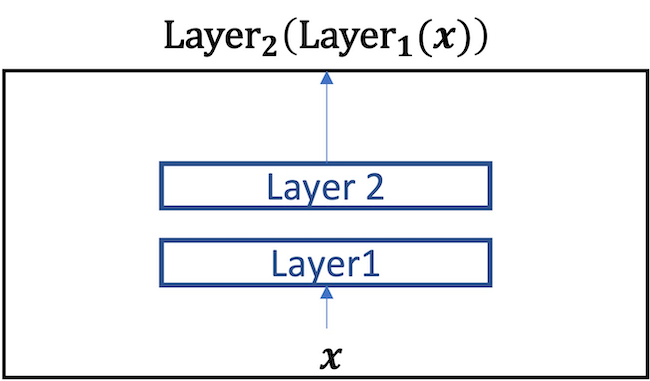

The idea for ResNet is: learn only the DIFFERENCE between input and output, i.e. input = x, output = x + some function of x

This is done by a "skip/residual connection":

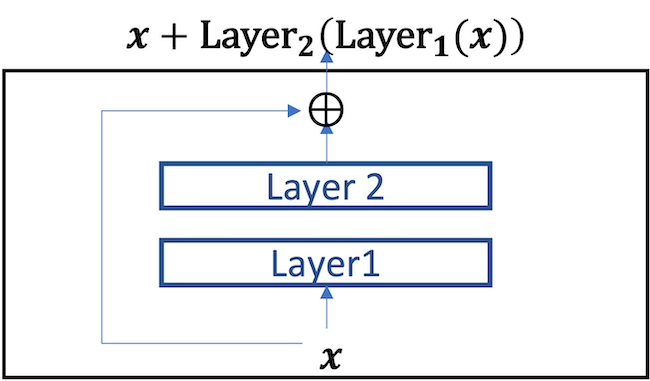


The Jacobian of such a layer will be the identity matrix + some other matrix!

However, such a block in its original form will always need to have output dimension = input dimension, otherwise you can't sum up x and the output of the Layers! 

To allow the dimensions to change, one could apply a 1x1 convolution to x to get it to the same size as the output layers. This version will be called `subsample=True`. 

The following class defines such a ResNetBlock Module: 

Add the missing code in the cell below:

The layers "within the residual connection" are `self.net` and should consist of 
- 3x3-Same Convolution (which padding size?) with c_in input and c_out output channels, stride = 1 if subsample = False else 2, without bias (since it's contained in BatchNorm)
- BatchNorm
- Activation Function
- 3x3 Same Convolution (which padding size?) with as much output as input channels and no bias
- batchnorm

The forward function: use the layers defined above in __init__ to create the architecture of a ResNet Block above, by applying the net to the input for one "arrow", and applying downsample to the input if subsample=True for the other arrow, then add them up. Only apply the activation function after the block. 

In [ ]:
class ResNetBlock(nn.Module):

    def __init__(self, c_in, act_fn, subsample=False, c_out=-1):
        """
        Inputs:
            c_in - Number of input features
            act_fn - Activation class constructor (e.g. nn.ReLU)
            subsample - If True, we want to apply a stride inside the block and reduce the output shape by 2 in height and width
            c_out - Number of output features. Note that this is only relevant if subsample is True, as otherwise, c_out = c_in
        """
        super().__init__()
        if not subsample:
            c_out = c_in
            
        # Network representing the layers "within the residual connection"
        self.net = nn.Sequential(
            #TODO
        )
        
        # 1x1 convolution with stride 2 means we take the upper left value, and transform it to new output size
        self.downsample = nn.Conv2d(c_in, c_out, kernel_size=1, stride=2) if subsample else None
        self.act_fn = act_fn()

    def forward(self, x):
        # TODO

The following class now defines a ResNet. Try to understand the architecture. To that end, note down the dimensions in the cell below if the input is 32x32x3 if the default parameters are used:

**Answer:** #TODO 


1. self.input_net: 

2. self.blocks: 

3.  self.output_net: 

In [ ]:
class ResNet(nn.Module):

    def __init__(self, num_classes=10, num_blocks=[3,3,3], c_hidden=[16,32,64], act_fn=nn.ReLU, **kwargs):
        """
        Inputs: 
            num_classes - Number of classification outputs (10 for CIFAR10)
            num_blocks - List with the number of ResNet blocks to use. The first block of each group uses downsampling, except the first.
            c_hidden - List with the hidden dimensionalities in the different blocks. Usually multiplied by 2 the deeper we go.
            act_fn_name - activation function to use
        """
        super().__init__()
        self.hparams = SimpleNamespace(num_classes=num_classes, 
                                       c_hidden=c_hidden, 
                                       num_blocks=num_blocks, 
                                       act_fn=act_fn,
                                       block_class=ResNetBlock)
        self._create_network()
        self._init_params()

    def _create_network(self):
        c_hidden = self.hparams.c_hidden
        
        # A first convolution on the original image to scale up the channel size
        self.input_net = nn.Sequential(
            nn.Conv2d(3, c_hidden[0], kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(c_hidden[0]),
            self.hparams.act_fn()
        )
        
        # Creating the ResNet blocks
        blocks = []
        for block_idx, block_count in enumerate(self.hparams.num_blocks):
            for bc in range(block_count):
                subsample = (bc == 0 and block_idx > 0) # Subsample the first block of each group, except the very first one.
                blocks.append(
                    self.hparams.block_class(c_in=c_hidden[block_idx if not subsample else (block_idx-1)],
                                             act_fn=self.hparams.act_fn,
                                             subsample=subsample,
                                             c_out=c_hidden[block_idx])
                )
        self.blocks = nn.Sequential(*blocks)
        
        # Mapping to classification output
        self.output_net = nn.Sequential(
            nn.AdaptiveAvgPool2d((1,1)),
            nn.Flatten(),
            nn.Linear(c_hidden[-1], self.hparams.num_classes)
        )

    def _init_params(self):
        # Based on our discussion in Tutorial 4, we should initialize the convolutions according to the activation function
        # Fan-out focuses on the gradient distribution, and is commonly used in ResNets
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity="relu")
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.input_net(x)
        x = self.blocks(x)
        x = self.output_net(x)
        return x

Create a ResNet model as `resnet_model` in the next cell. 

Train it by going through the following steps: 
- define the `optimizer` to be Adam optimizer with `lr=0.001` and `weight_decay=1e-4`
- again, define a StepLR scheduler like before with the same parameters
- define the loss_module as cross-entropy loss
- use the training function we defined above and train for 5 epochs on the training set

Test the model on the test data.

## Transfer Learning

### Finetuning an entire ResNet

Load a [ResNet18](https://pytorch.org/vision/master/models/generated/torchvision.models.resnet18.html?highlight=resnet18#torchvision.models.resnet18) pretrained on Imagenet1K_V1 and call it `resnet_18_finetune`. 
The last layer of this resnet_18 can be accessed via `resnet_18_finetune.fc`, which is a Linear Layer, and the number of its input features can be accessed via `resnet_18_finetune.fc.in_features`. 
We want to replace this last layer by our own Linear Layer, which should have as many output units as classes we want to predict here. 
Do that by simply "redefining" `resnet_18_finetune.fc` as a nn.Linear layer with the correct in- and output sizes. 


In [ ]:
resnet_18_finetune = torchvision.models.resnet18(weights='IMAGENET1K_V1')


Now define an optimizer which uses a different learning rate on the last layer than on the rest (because we want the new last layer to train more quickly than the already pretrained layers!) Use 1e-3 on the base layers and 1e-2 on the last layer by specifying 

```[{'params': resnet_18_finetune.parameters()}, 
    {'params': resnet_18_finetune.fc.parameters(), 'lr': 1e-2}
    ], lr=1e-3```

inside the optimizer. 

Also define the LR-Schedule and then fine-tune this model for a few epochs. Evaluate the model on the test data. 

### Using ResNet as a Feature Extractor

Here, we want to fix the pretrained weights of the ResNet (apart from the final layer) and not fine-tune them any further. Only the last layer will be trained. To freeze the weights of layers during training, one uses `requires_grad=False` on the parameters one wants to freeze. I.e. proceed as follows: 
- again, load a pretrained ResNet18, this time as `resnet_18_fe`. 
- for all parameters in `resnet_18_fe.parameters()`, set `param.requires_grad=False`
- Again, replace the last layer with a suitable Linear layer

In [ ]:
resnet_18_fe = torchvision.models.resnet18(weights='IMAGENET1K_V1')


Push the model to the device and define the optimizer - Attention! This time, not all parameters are given to the optimizer, but only those of the last fc-layer!
Train the model on a few epochs and evaluate.